<a href="https://colab.research.google.com/github/ColmTalbot/windowing-in-parameter-estimation/blob/main/notebooks/window_factor_pp_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pp-test for different window correction factors

We want to compare two different forms of the likelihood

$$
\ln p(d | \theta) \sim -\frac{2}{\beta T} \sum_i \frac{\left|\tilde{d}_{i} - \tilde{h}_{i}(\theta)\right|^2}{S_{i}}
$$

where the quantitity $\beta$ is either $1$ or $1 - 5\alpha / 8$, where $\alpha$ is the Tukey window parameter.

To test this, we run a pp-test with only one varying parameter at very high SNR and with a smooth turn on for the window ($\alpha=0.5$).
We choose distance as the parameter because the likelihood has an extremely simple form in this case.

In [1]:
!pip install "bilby<2.6" lalsuite gwpy nestle

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.9/983.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.9/179.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.8 MB/s eta 0:00:00
  Created whee

In [2]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended texlive-science

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-gfs-baskerville
  fonts-gfs-porson fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 ghostscript libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern pfb2t1c2pfb poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-lang-greek
  texlive-latex-base texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | f

In [13]:
import bilby
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom, ks_1samp, norm, uniform
from tqdm import trange

import matplotlib as mpl

mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath} \usepackage{amssymb}"
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "cm"
mpl.rcParams["axes.grid"] = False
mpl.rcParams["font.size"] = 16

import lal

_ = lal.swig_redirect_standard_output_error(False)

%matplotlib inline

In [148]:
duration = 4
sampling_frequency = 512
roll_off = 1

bilby.core.utils.logger.setLevel("ERROR")

np.random.seed(250703)
bilby.core.utils.random.seed(250703)

In [149]:
injection_parameters = dict(
    mass_1=66.0,
    mass_2=59.0,
    a_1=0.0,
    a_2=0.0,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

waveform_arguments = dict(waveform_approximant="IMRPhenomD", reference_frequency=50)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
)

In [150]:
prior = bilby.core.prior.Uniform(100, 1000)
distances = np.linspace(prior.minimum, prior.maximum, 10000)
prior_prob = prior.prob(distances)

In [151]:
injections = list()
pvals = list()
pvals_beta = list()
cumulative = list()
cumulative_beta = list()

CORRECTION = False

for _ in trange(1000):

    distance = prior.sample()
    injection_parameters["luminosity_distance"] = distance
    injections.append(distance)

    ifos = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
    ifos.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=injection_parameters["geocent_time"] - 2,
    )

    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters
    )
    for ifo in ifos:
        data = ifo.strain_data.to_gwpy_timeseries()
        ifo.strain_data.roll_off = roll_off
        ifo.strain_data.set_from_gwpy_timeseries(data)

    likelihood = bilby.gw.GravitationalWaveTransient(
        interferometers=ifos,
        waveform_generator=waveform_generator,
    )
    likelihood.parameters.update(injection_parameters)

    waveform_polarizations = waveform_generator.frequency_domain_strain(
        injection_parameters
    )

    total_snrs = likelihood._CalculatedSNRs()
    for interferometer in ifos:
        per_detector_snr = likelihood.calculate_snrs(
            waveform_polarizations=waveform_polarizations,
            interferometer=interferometer)
        total_snrs += per_detector_snr

    h_inner_h = total_snrs.optimal_snr_squared
    d_inner_h = total_snrs.d_inner_h
    scale = injection_parameters["luminosity_distance"] / distances

    ln_l_array = -h_inner_h * scale**2 / 2 + d_inner_h.real * scale
    ln_l_array -= max(ln_l_array)

    # w/o correction
    like = np.exp(ln_l_array)
    post = like * prior_prob
    post /= np.trapezoid(post, distances)
    pvals.append(sum(post[distances < distance]) / sum(post))

    # w correction
    beta = ifo.strain_data.window_factor
    scaled_ln_l_array = ln_l_array * beta
    like = np.exp(scaled_ln_l_array)
    post = like * prior_prob
    post /= np.trapezoid(post, distances)
    pvals_beta.append(sum(post[distances < distance]) / sum(post))

    test = ks_1samp(pvals, uniform.cdf)
    cumulative.append(test.pvalue)
    test = ks_1samp(pvals_beta, uniform.cdf)
    cumulative_beta.append(test.pvalue)

100%|██████████| 1000/1000 [01:08<00:00, 14.63it/s]


## Inspect the results

We can now look at how our p-value evolves with the population size for both cases. The current method clearly fails. The corrected version is better, but still not ideal. This could be because of discretization issues with the gridded likelihoods, or possibly correlations between frequency bins induced by the window.

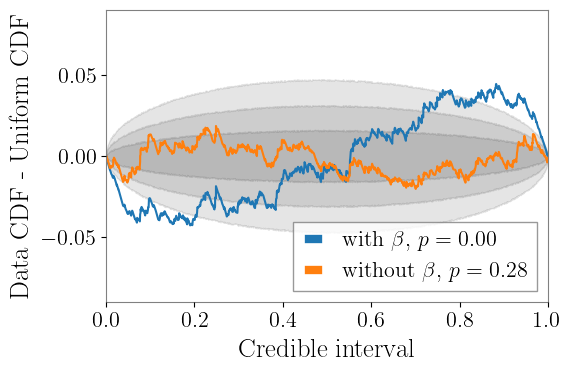

In [152]:
xvals = np.sort(np.random.uniform(0, 1, len(pvals)))

fig = plt.figure(figsize=(6, 4))

plt.plot(xvals, np.sort(pvals) - xvals, label=f"with $\\beta$, $p={cumulative[-1]:.2f}$")
plt.plot(xvals, np.sort(pvals_beta) - xvals, label=f"without $\\beta$, $p={cumulative_beta[-1]:.2f}$")

alpha = 0.1
for ci in [0.68, 0.95, 0.997]:
    edge_of_bound = (1. - ci) / 2.
    lower = binom.ppf(1 - edge_of_bound, len(pvals), xvals) / len(pvals)
    upper = binom.ppf(edge_of_bound, len(pvals), xvals) / len(pvals)
    # The binomial point percent function doesn't always return 0 @ 0,
    # so set those bounds explicitly to be sure
    lower[0] = 0
    upper[0] = 0
    plt.fill_between(xvals, lower - xvals, upper - xvals, alpha=alpha, color='k')

plt.xlabel("Credible interval")
plt.ylabel("Data CDF - Uniform CDF")
plt.legend(loc="lower right")
plt.xlim(0, 1)
plt.ylim(-0.09, 0.09)
plt.tight_layout()
plt.savefig("pp-test.pdf")
plt.show()
plt.close()

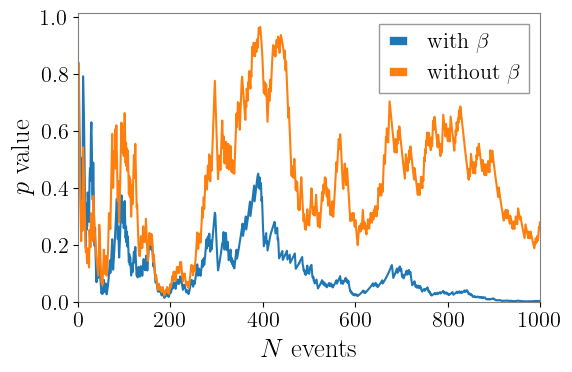

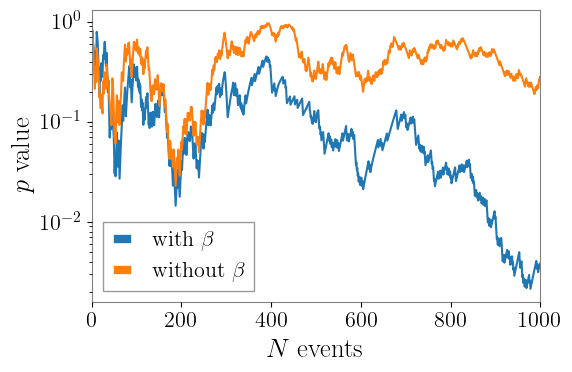

In [153]:
fig = plt.figure(figsize=(6, 4))
plt.plot(cumulative, label="with $\\beta$")
plt.plot(cumulative_beta, label="without $\\beta$")
plt.xlim(0, len(cumulative))
plt.ylim(0)
plt.xlabel("$N$ events")
plt.ylabel("$p$ value")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("p-value-vs-n.pdf")
plt.show()
plt.close()

fig = plt.figure(figsize=(6, 4))
plt.plot(cumulative, label="with $\\beta$")
plt.plot(cumulative_beta, label="without $\\beta$")
plt.xlim(0, len(cumulative))
plt.xlabel("$N$ events")
plt.ylabel("$p$ value")
plt.legend(loc="best")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()